In [1]:
import wandb
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from utils import update_dir_name
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Get wandb run history
api = wandb.Api()
wandb_path = os.path.join("..", "wandb")

In [2]:
training_config = {
    'n_epochs': 100,
    'p_test': 0.1,

    'optimizer': 'Muon',
    'batch_size': 100,
    'learning_rate': 0.002,
    'weight_decay': 0.0,
    'p_electrodes_per_stream': 0.5,
    
    'train_subject_trials': [("btbank1", 0), ("btbank1", 1), ("btbank2", 4), ("btbank2", 5), ("btbank3", 1), ("btbank3", 2), ("btbank7", 1), ("btbank10", 1)],
    'eval_subject_trials': [("btbank1", 2), ("btbank2", 6), ("btbank3", 0), ("btbank7", 0), ("btbank10", 0)],
    
    'data_dtype': torch.float16,

    'random_string': "X2",
}
model_config = {
    'sample_timebin_size': 256,
    'max_frequency_bin': 64,
    'max_n_timebins': 24,
    'max_n_electrodes': 128,

    'init_normalization': True, # XXX rename to a more sensible name later

    'electrode_embedding': {
        'type': 'learned', # coordinate_init, noisy_coordinate, learned
        'coordinate_noise_std': 0.0, # only relevant for noisy_coordinate type; note coordinates are normalized to be within [0,1]
        'embedding_dim': None,
    },

    'dtype': torch.bfloat16,

    'transformer': {
        'd_model': 192,
        'n_heads': 12,
        'n_layers_electrode': 5,
        'n_layers_time': 5,
        'dropout': 0.2,
    },
}
cluster_config = {
    'save_model_every_n_epochs': 20,
    'eval_model_every_n_epochs': 5,

    'wandb_project': 'mini_bfm_exp',

    'cache_subjects': True,

    'num_workers_init': 1,
    'num_workers_dataloaders': 4,
    'num_workers_eval': 4,
    'prefetch_factor': 2,
}

In [5]:
embedding_dims=[192, 96, 48, 24, -1]
random_strings = ["ED_1", "ED_2", "ED_3", "WD_7", "WD_8", "WD_9"]

# Initialize histories dict
histories = {ed: [] for ed in embedding_dims}

# Generate all run IDs and collect histories
for ed in embedding_dims:
    for rs in random_strings:
        training_config['random_string'] = rs
        model_config['electrode_embedding']['embedding_dim'] = ed if ed > 0 else None
        run_id = update_dir_name(model_config, training_config, cluster_config)
        
        runs = api.runs("andrii-mit/mini_bfm_exp", filters={"display_name": run_id})
        if len(runs) > 0:
            run = runs[0]
            history = run.history()
            if history['_step'].max() == 99:  # Only include if trained for full 100 epochs
                histories[ed].append(history)

for ed in embedding_dims:
    print(f"embedding dim {ed}: {len(histories[ed])} runs")

embedding dim 192: 3 runs
embedding dim 96: 3 runs
embedding dim 48: 3 runs
embedding dim 24: 3 runs
embedding dim -1: 3 runs


In [6]:
metrics = ['train_loss', 'test_loss', 'eval_auroc/average_speech', 'eval_auroc/average_volume']
metric_names = ['Training Loss', 'Test Loss', 'Decoding Speech AUROC', 'Decoding Volume AUROC']
n_last_measurements = 3

# Initialize results dictionary
results = {ed: {metric: [] for metric in metrics} 
          for ed in embedding_dims}

# Calculate means for each run
for ed in embedding_dims:
    for history in histories[ed]:
        for metric in metrics:
            results[ed][metric].append(history[metric].iloc[-n_last_measurements:].mean())

# Print results
for ed in embedding_dims:
    print(f"\nembedding dim {ed}:")
    for metric in metrics:
        values = results[ed][metric]
        if values:
            mean = sum(values) / len(values)
            print(f"{metric}: {mean:.4f} (across {len(values)} runs)")



embedding dim 192:
train_loss: 0.2922 (across 3 runs)
test_loss: 0.4379 (across 3 runs)
eval_auroc/average_speech: 0.8281 (across 3 runs)
eval_auroc/average_volume: 0.7192 (across 3 runs)

embedding dim 96:
train_loss: 0.2938 (across 3 runs)
test_loss: 0.4440 (across 3 runs)
eval_auroc/average_speech: 0.8417 (across 3 runs)
eval_auroc/average_volume: 0.7043 (across 3 runs)

embedding dim 48:
train_loss: 0.3081 (across 3 runs)
test_loss: 0.4633 (across 3 runs)
eval_auroc/average_speech: 0.8350 (across 3 runs)
eval_auroc/average_volume: 0.6670 (across 3 runs)

embedding dim 24:
train_loss: 0.3228 (across 3 runs)
test_loss: 0.4842 (across 3 runs)
eval_auroc/average_speech: 0.8360 (across 3 runs)
eval_auroc/average_volume: 0.7247 (across 3 runs)

embedding dim -1:
train_loss: 0.2912 (across 3 runs)
test_loss: 0.4405 (across 3 runs)
eval_auroc/average_speech: 0.8368 (across 3 runs)
eval_auroc/average_volume: 0.6973 (across 3 runs)


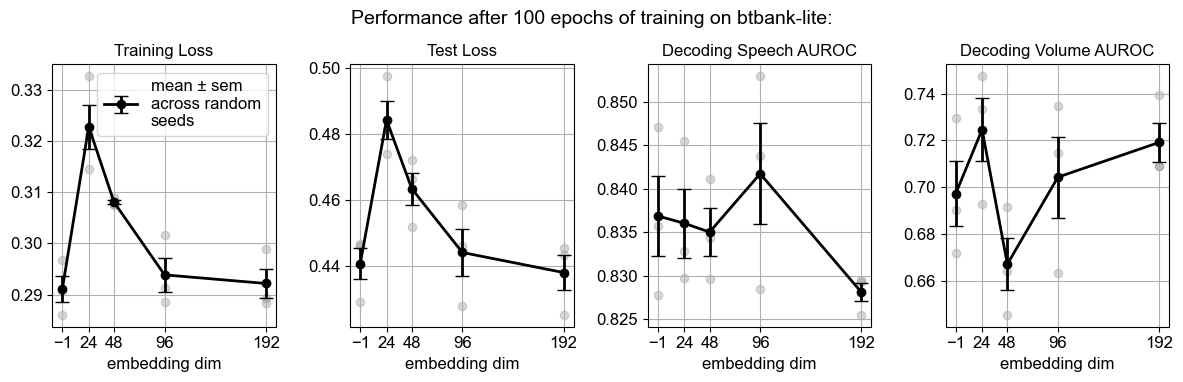

In [7]:
# Set error bar type ('std' for standard deviation or 'sem' for standard error of mean)
error_type = 'sem'

fig, axes = plt.subplots(1, len(metrics), figsize=(3*len(metrics), 4))

for i, metric in enumerate(metrics):
    means = []
    errors = []
    ps = []
    all_values = []
    all_ps = []
    
    for ed in embedding_dims:
        values = results[ed][metric]
        if values:  # Only include if we have data
            means.append(np.mean(values))
            if error_type == 'std':
                errors.append(np.std(values))
            else:  # sem
                errors.append(np.std(values) / np.sqrt(len(values)))
            ps.append(ed)
            # Store individual points
            all_values.extend(values)
            all_ps.extend([ed] * len(values))
    
    # Plot individual points with some jitter and transparency
    jitter = 0.01
    axes[i].scatter(
        [p + np.random.uniform(-jitter, jitter) for p in all_ps],
        all_values,
        alpha=0.3,
        color='gray',
        zorder=1
    )
    
    # Plot mean and error bars on top
    error_label = 'mean ± std' if error_type == 'std' else 'mean ± sem'
    error_label += '\nacross random\nseeds'
    axes[i].errorbar(ps, means, yerr=errors, marker='o', capsize=5, 
                    color='black', zorder=2, label=error_label,
                    linewidth=2)
    
    axes[i].set_xticks(embedding_dims)
    axes[i].set_xlabel('embedding dim')
    #axes[i].set_ylabel('Value')
    axes[i].set_title(metric_names[i], color='black', fontsize=12)
    axes[i].grid(True)
    if i==0: axes[i].legend()

plt.suptitle('Performance after 100 epochs of training on btbank-lite:', color='black', fontsize=14, y=0.95)
plt.tight_layout()
plt.savefig('analyses/exp_ed.pdf', bbox_inches='tight', dpi=300)
plt.show()
